## Model 2

This model doubles the CP from model 1. For that we will use less filters. In this case the CP is ((2^3)^2) / 10 = 6.4.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [2]:
model = models.Sequential()
model.add(layers.Conv3D(5, (4, 4, 4), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(10, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(5, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (4, 4, 4), strides=2, padding="same", activation = None))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 20, 20, 5)      325       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 10)     3210      
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 5)      3205      
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 12, 40, 40, 1)     321       
Total params: 7,061
Trainable params: 7,061
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [5]:
months = 10
files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset(files, combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [6]:
history = model.fit(dg_train, validation_data = dg_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 0.7885 - val_loss: 0.6047
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.5299 - val_loss: 0.3878
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.3136 - val_loss: 0.2358
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.1789 - val_loss: 0.1245
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.1115 - val_loss: 0.0962
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0812 - val_loss: 0.0730
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0656 - val_loss: 0.0578
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0596 - val_loss: 0.0510
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0476 - val_loss: 0.0419
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0393 - val_loss: 0.0356
Epoch 11

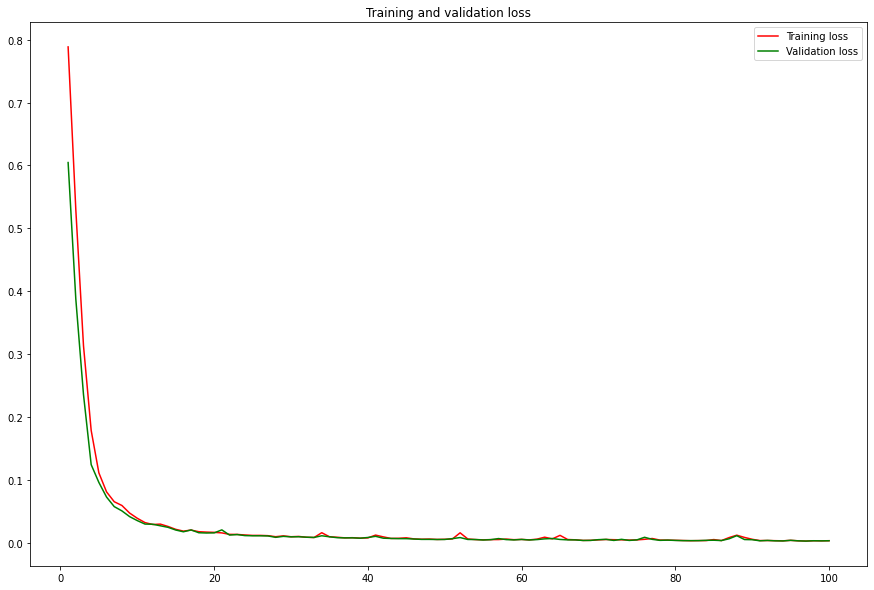

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

f = plt.figure(figsize=(15,10))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

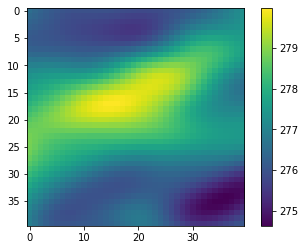

In [8]:
fig, ax = plt.subplots()
a = dg_train.__getitem__(8)[0] 
bb = plt.imshow(a[0,10,:,:,0]  * dg_train.std.values[0] + dg_train.mean.values[0],  cmap='viridis')
fig.colorbar(bb, orientation='vertical')
plt.show()

In [9]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

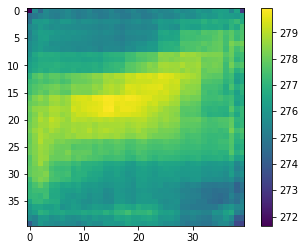

In [10]:
fig, ax = plt.subplots()
bb = plt.imshow((result[0,10,:,:,0] * dg_train.std.values[0] + dg_train.mean.values[0]))
fig.colorbar(bb, orientation='vertical')
plt.show()

In [11]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

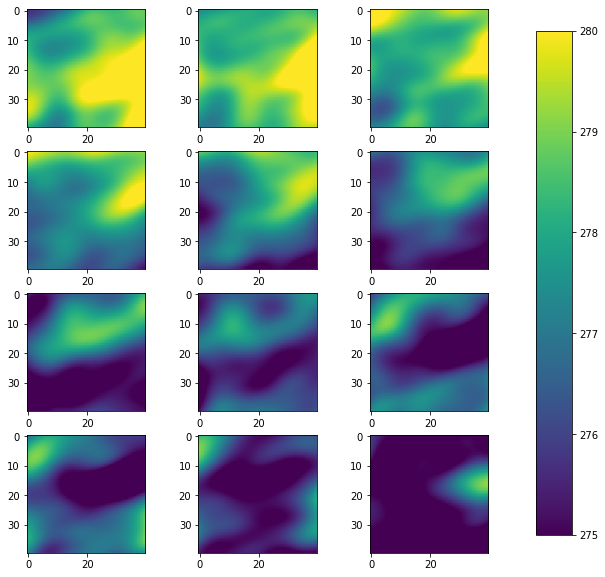

In [12]:
fig, ax = plt.subplots(4,3, figsize=(10,10))

count = 0
for i in range(4):
    for j in range(3):
        img = test_data[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=275, vmax=280)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

Decompressed:

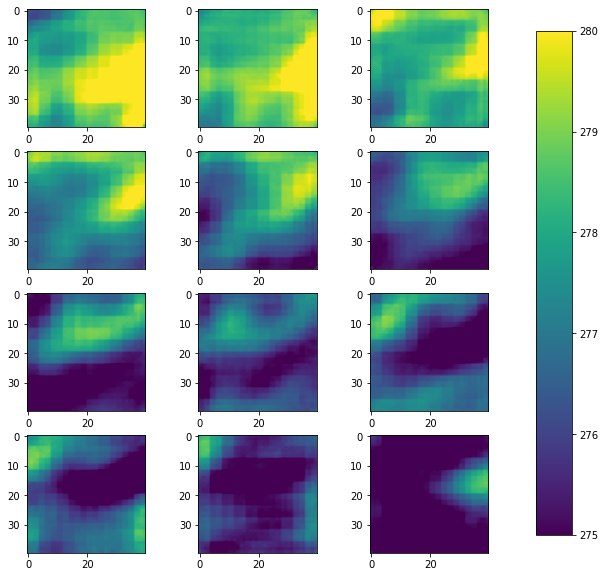

In [13]:
result2 = model(test_data).numpy()

fig, ax = plt.subplots(4,3, figsize=(10,10))

count = 0
for i in range(4):
    for j in range(3):
        img = result2[0,count,:,:,0] *std.values[0] + mean.values[0]
        im = ax[i, j].imshow(img,  vmin=275, vmax=280)
        count=count +1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im,  cax=cbar_ax)
plt.show()

It's not a surprise we don't get such good results as before. How can we increase the CP without deteriorating the quality of our output?

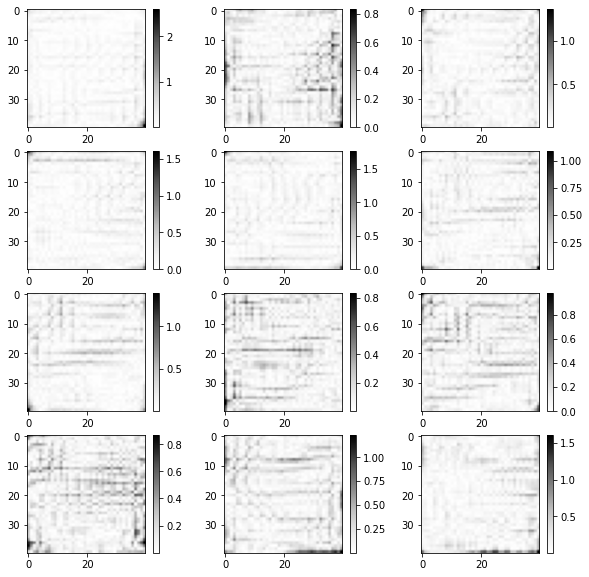

In [15]:
a = result2*std.values[0] + mean.values[0]
b = test_data*std.values[0] + mean.values[0]

result3 = np.absolute(a-b)

fig, ax = plt.subplots(4, 3, figsize=(10,10))
count = 0
for i in range(4):
    for j in range(3):
        img = result3[0,count,:,:,0] 
        im = ax[i, j].imshow(img, cmap = 'Greys')
        plt.colorbar(im, ax=ax[i, j])
        count = count +1

plt.show()